# Sub-sampling from original file
Original WARC file is 5.5GB of webpages. So i am going to take 100k of sample from it.

In [29]:
!pip install warcio tqdm langdetect pycld2 langid

Found 31 WARC files: CC-NEWS-20250103095544-00180.warc, CC-NEWS-20250102092617-00168.warc, CC-NEWS-20250101055537-00157.warc, CC-NEWS-20250101233509-00164.warc, CC-NEWS-20250102214004-00175.warc, CC-NEWS-20250103181014-00185.warc, CC-NEWS-20250103145501-00183.warc, CC-NEWS-20250101110352-00159.warc, CC-NEWS-20250102074538-00167.warc, CC-NEWS-20250102110149-00169.warc, CC-NEWS-20200110212037-00310.warc, CC-NEWS-20250102140759-00171.warc, CC-NEWS-20250102053830-00166.warc, CC-NEWS-20250103060152-00178.warc, CC-NEWS-20250101182853-00162.warc, CC-NEWS-20250102155145-00172.warc, CC-NEWS-20250101204758-00163.warc, CC-NEWS-20250103080404-00179.warc, CC-NEWS-20250102192440-00174.warc, CC-NEWS-20250102122438-00170.warc, CC-NEWS-20250102173620-00173.warc, CC-NEWS-20250103114344-00181.warc, CC-NEWS-20250101083312-00158.warc, CC-NEWS-20250101160900-00161.warc, CC-NEWS-20250103031223-00177.warc, CC-NEWS-20250103000559-00176.warc, CC-NEWS-20250101133323-00160.warc, CC-NEWS-20250103131849-00182.warc,

Processing WARC files: 100%|██████████| 31/31 [10:16<00:00, 19.88s/it]



Summary Statistics:
Total records analyzed: 810797
Total files analyzed: 31
Average file size: 1154.69 MB

Top 10 domains:
  familio.org: 29673
  webcatalog.io: 24311
  thetibetpost.com: 21395
  www.mexc.com: 19736
  news.livedoor.com: 17898
  www.zazoom.it: 14853
  mirtesen.ru: 14158
  www.mexc.co: 9231
  dientuungdung.vn: 7336
  www.sondakika.com: 5670

Content type distribution:
  text/html: 807240
  unknown: 2651
  text/HTML: 606
  image/webp: 121
  application/atom+xml: 71
  application/json: 68
  text/html, charset=iso-8859-1: 24
  application/pdf: 5
  application/xml: 3
  image/jpeg: 3

Status code distribution:
  200: 2005

Full statistics exported to warc_stats.json


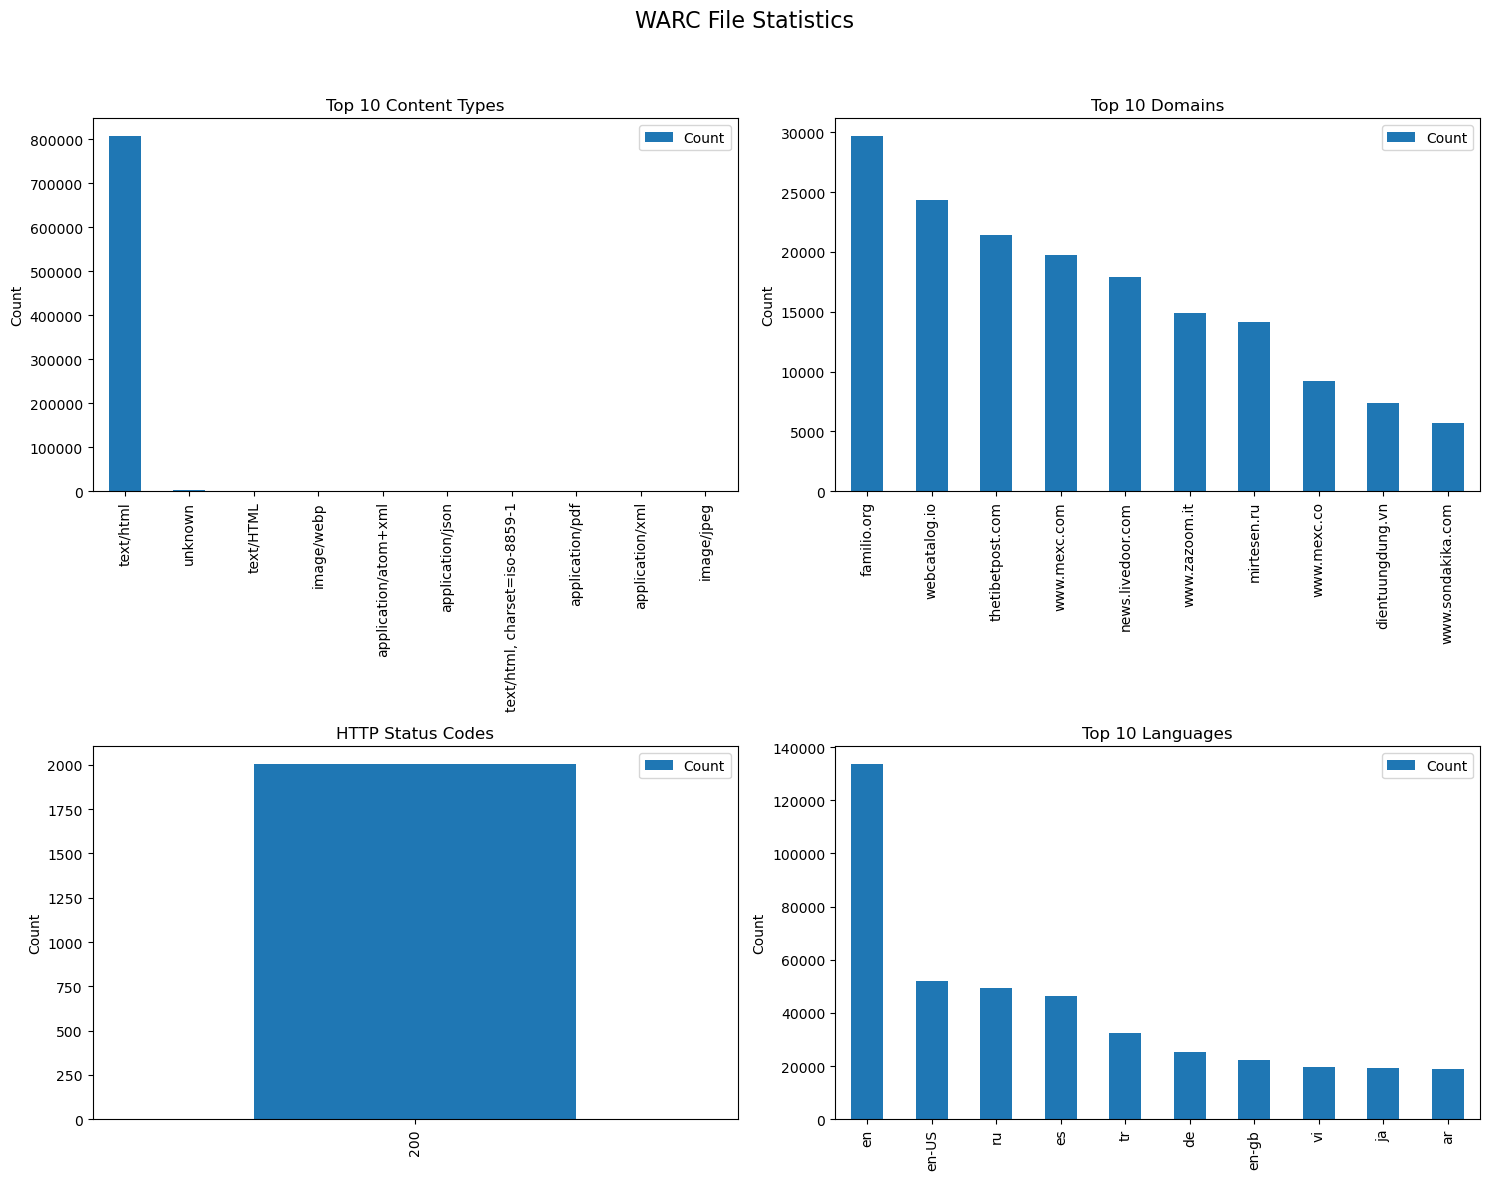

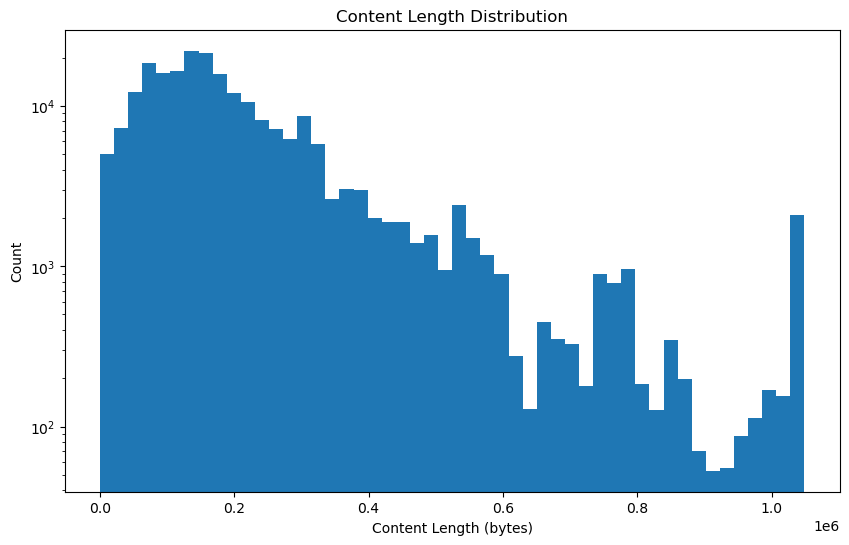

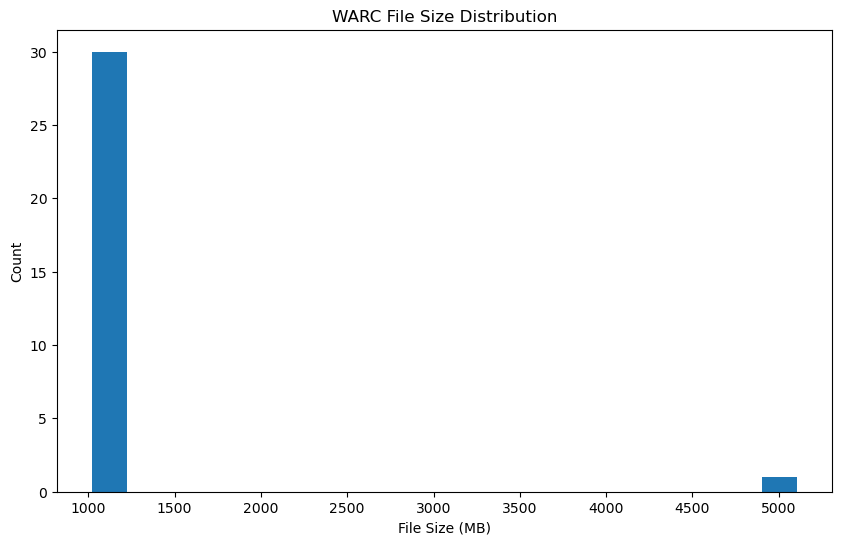

In [30]:
import os
from warcio.archiveiterator import ArchiveIterator
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
from urllib.parse import urlparse
import json

def normalize_url(url):
    """Normalize URL to improve matching"""
    if not url:
        return ""
    
    # Parse URL
    parsed = urlparse(url)
    
    # Convert to lowercase
    netloc = parsed.netloc.lower()
    
    # Remove 'www.' if present
    if netloc.startswith('www.'):
        netloc = netloc[4:]
    
    # Remove trailing slash from path
    path = parsed.path
    if path.endswith('/'):
        path = path[:-1]
    
    # Reconstruct cleaned URL (without query parameters and fragments for better matching)
    clean_url = f"{parsed.scheme}://{netloc}{path}"
    
    return clean_url

def analyze_warc_file(warc_path):
    """Analyze a single WARC file and extract key statistics"""
    stats = {
        'num_records': 0,
        'content_types': Counter(),
        'domains': Counter(),
        'status_codes': Counter(),
        'content_lengths': [],
        'languages': Counter(),
        'urls': []
    }
    
    try:
        with open(warc_path, 'rb') as f:
            for record in ArchiveIterator(f):
                if record.rec_type == 'response':
                    stats['num_records'] += 1
                    
                    # Extract content type
                    content_type = record.http_headers.get_header('Content-Type', 'unknown')
                    main_type = content_type.split(';')[0].strip()
                    stats['content_types'][main_type] += 1
                    
                    # Extract domain
                    url = record.rec_headers.get_header('WARC-Target-URI')
                    if url:
                        stats['urls'].append(url)
                        domain = urlparse(url).netloc
                        stats['domains'][domain] += 1
                    
                    # Extract status code
                    status = record.http_headers.get_header('Status')
                    if status:
                        stats['status_codes'][status.split()[0]] += 1
                    
                    # Extract content length
                    content_length = record.http_headers.get_header('Content-Length')
                    if content_length and content_length.isdigit():
                        stats['content_lengths'].append(int(content_length))
                    
                    # Extract language
                    content_language = record.http_headers.get_header('Content-Language', '')
                    if content_language:
                        stats['languages'][content_language] += 1
                    else:
                        # Try to extract language from HTML content for text/html
                        if main_type == 'text/html' and record.content_stream():
                            try:
                                content = record.content_stream().read(10000).decode('utf-8', errors='ignore')
                                lang_match = re.search(r'<html[^>]*lang=["\']([a-zA-Z-]+)["\']', content)
                                if lang_match:
                                    stats['languages'][lang_match.group(1)] += 1
                            except Exception as e:
                                pass
    except Exception as e:
        print(f"Error processing {warc_path}: {e}")
        
    return stats

def analyze_warc_files(warc_files):
    """Analyze multiple WARC files and combine statistics"""
    all_stats = {
        'num_records': 0,
        'content_types': Counter(),
        'domains': Counter(),
        'status_codes': Counter(),
        'content_lengths': [],
        'languages': Counter(),
        'files_analyzed': 0,
        'file_sizes': [],
        'urls': []
    }
    
    for warc_file in tqdm(warc_files, desc="Processing WARC files"):
        file_size = os.path.getsize(warc_file) / (1024 * 1024)  # Size in MB
        all_stats['file_sizes'].append(file_size)
        
        file_stats = analyze_warc_file(warc_file)
        
        # Merge statistics
        all_stats['num_records'] += file_stats['num_records']
        all_stats['content_types'] += file_stats['content_types']
        all_stats['domains'] += file_stats['domains']
        all_stats['status_codes'] += file_stats['status_codes']
        all_stats['content_lengths'].extend(file_stats['content_lengths'])
        all_stats['languages'] += file_stats['languages']
        all_stats['urls'].extend(file_stats['urls'])
        all_stats['files_analyzed'] += 1
    
    return all_stats

def visualize_stats(stats):
    """Create visualizations of the WARC statistics"""
    # Create a figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('WARC File Statistics', fontsize=16)
    
    # Content Types
    content_df = pd.DataFrame.from_dict(dict(stats['content_types'].most_common(10)), 
                                        orient='index', columns=['Count'])
    content_df.plot(kind='bar', ax=axs[0, 0], title='Top 10 Content Types')
    axs[0, 0].set_ylabel('Count')
    
    # Domains
    domain_df = pd.DataFrame.from_dict(dict(stats['domains'].most_common(10)), 
                                      orient='index', columns=['Count'])
    domain_df.plot(kind='bar', ax=axs[0, 1], title='Top 10 Domains')
    axs[0, 1].set_ylabel('Count')
    
    # Status Codes
    status_df = pd.DataFrame.from_dict(dict(stats['status_codes']), 
                                      orient='index', columns=['Count'])
    status_df.plot(kind='bar', ax=axs[1, 0], title='HTTP Status Codes')
    axs[1, 0].set_ylabel('Count')
    
    # Languages
    if stats['languages']:
        lang_df = pd.DataFrame.from_dict(dict(stats['languages'].most_common(10)), 
                                        orient='index', columns=['Count'])
        lang_df.plot(kind='bar', ax=axs[1, 1], title='Top 10 Languages')
        axs[1, 1].set_ylabel('Count')
    else:
        axs[1, 1].text(0.5, 0.5, 'No language data found', ha='center', va='center')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Content Length Distribution
    if stats['content_lengths']:
        plt.figure(figsize=(10, 6))
        plt.hist(stats['content_lengths'], bins=50)
        plt.title('Content Length Distribution')
        plt.xlabel('Content Length (bytes)')
        plt.ylabel('Count')
        plt.yscale('log')
        plt.show()
    
    # File Size Distribution
    plt.figure(figsize=(10, 6))
    plt.hist(stats['file_sizes'], bins=20)
    plt.title('WARC File Size Distribution')
    plt.xlabel('File Size (MB)')
    plt.ylabel('Count')
    plt.show()

# Find all WARC files in the current directory
warc_files = [f for f in os.listdir('.') if f.endswith('.warc')]

if warc_files:
    print(f"Found {len(warc_files)} WARC files: {', '.join(warc_files)}")
    
    # Analyze the files
    stats = analyze_warc_files(warc_files)
    
    # Display summary stats
    print("\nSummary Statistics:")
    print(f"Total records analyzed: {stats['num_records']}")
    print(f"Total files analyzed: {stats['files_analyzed']}")
    print(f"Average file size: {sum(stats['file_sizes'])/len(stats['file_sizes']):.2f} MB")
    
    print("\nTop 10 domains:")
    for domain, count in stats['domains'].most_common(10):
        print(f"  {domain}: {count}")
    
    print("\nContent type distribution:")
    for content_type, count in stats['content_types'].most_common(10):
        print(f"  {content_type}: {count}")
    
    print("\nStatus code distribution:")
    for status, count in stats['status_codes'].most_common():
        print(f"  {status}: {count}")
    
    # Export full statistics to JSON
    with open('warc_stats.json', 'w') as f:
        # Convert Counters to regular dictionaries
        export_stats = {
            'num_records': stats['num_records'],
            'content_types': dict(stats['content_types']),
            'domains': dict(stats['domains']),
            'status_codes': dict(stats['status_codes']),
            'languages': dict(stats['languages']),
            'files_analyzed': stats['files_analyzed'],
            'sample_urls': stats['urls'][:100]  # Save only the first 100 URLs to keep file size reasonable
        }
        json.dump(export_stats, f, indent=2)
    
    print("\nFull statistics exported to warc_stats.json")
    
    # Visualize the results
    visualize_stats(stats)
    
    # Save URLs to separate file for Turkish analysis
    with open('extracted_urls.txt', 'w') as f:
        for url in stats['urls']:
            f.write(f"{url}\n")
            
else:
    print("No WARC files found in the current directory")

## Detect URLs that has Turkish content

In [31]:
import re
import os
from warcio.archiveiterator import ArchiveIterator
from urllib.parse import urlparse

def is_turkish_text(content, min_unique=3, debug=False):
    """
    İçerikteki Türkçe karakterler arasında, farklı (unique) karakter sayısı min_unique'ten fazla ise
    içerik Türkçe kabul edilir.
    """
    # Türkçe karakterler: ç, ğ, ı, ö, ş, ü (büyük ve küçük)
    turkish_chars = "çğıöşüÇĞİÖŞÜ"
    matches = re.findall(f"[{turkish_chars}]", content)
    unique_chars = set(matches)
    if debug:
        print(f"Bulunan karakterler: {matches}")
        print(f"Unique karakterler: {unique_chars}")
    return len(unique_chars) > min_unique

def list_turkish_urls_by_chars(warc_file, read_bytes=20000, debug=False):
    """Bir WARC dosyasındaki, içerikte Türkçe karakterlerin varlığına bakarak Türkçe URL'leri döndürür."""
    turkish_urls = []
    try:
        with open(warc_file, 'rb') as f:
            for record in ArchiveIterator(f):
                if record.rec_type == 'response':
                    try:
                        content = record.content_stream().read(read_bytes).decode('utf-8', errors='ignore')
                        if content.strip() and is_turkish_text(content, debug=debug):
                            url = record.rec_headers.get_header('WARC-Target-URI')
                            if url:
                                turkish_urls.append(url)
                    except Exception as error:
                        if debug:
                            print("Record işlenirken hata:", error)
                        continue
    except Exception as e:
        print(f"Error processing {warc_file}: {e}")
    return turkish_urls

# WARC dosyalarını işleyip Türkçe URL'leri toplayalım
all_turkish_urls = []
warc_files = [f for f in os.listdir('.') if f.endswith('.warc')]

for warc_file in warc_files:
    urls = list_turkish_urls_by_chars(warc_file, debug=False)
    print(f"{warc_file} içinde {len(urls)} adet Türkçe URL bulundu.")
    all_turkish_urls.extend(urls)

print(f"\nToplamda {len(all_turkish_urls)} adet Türkçe URL bulundu.")

# all_turkish_urls listesinde bulunan tüm URL'lerden unique domain'leri alalım
unique_domains = {urlparse(url).netloc for url in all_turkish_urls if url}

print("Unique domains:", unique_domains)
for domain in unique_domains:
    print(domain)
#for url in all_turkish_urls:
#    print(url)

CC-NEWS-20250103095544-00180.warc içinde 1979 adet Türkçe URL bulundu.
CC-NEWS-20250102092617-00168.warc içinde 1328 adet Türkçe URL bulundu.
CC-NEWS-20250101055537-00157.warc içinde 1257 adet Türkçe URL bulundu.
CC-NEWS-20250101233509-00164.warc içinde 320 adet Türkçe URL bulundu.
CC-NEWS-20250102214004-00175.warc içinde 960 adet Türkçe URL bulundu.
CC-NEWS-20250103181014-00185.warc içinde 826 adet Türkçe URL bulundu.
CC-NEWS-20250103145501-00183.warc içinde 1302 adet Türkçe URL bulundu.
CC-NEWS-20250101110352-00159.warc içinde 1441 adet Türkçe URL bulundu.
CC-NEWS-20250102074538-00167.warc içinde 1222 adet Türkçe URL bulundu.
CC-NEWS-20250102110149-00169.warc içinde 1750 adet Türkçe URL bulundu.
CC-NEWS-20200110212037-00310.warc içinde 1598 adet Türkçe URL bulundu.
CC-NEWS-20250102140759-00171.warc içinde 1345 adet Türkçe URL bulundu.
CC-NEWS-20250102053830-00166.warc içinde 841 adet Türkçe URL bulundu.
CC-NEWS-20250103060152-00178.warc içinde 1224 adet Türkçe URL bulundu.
CC-NEWS-20

## Merge found URLs and BTK URLs

In [32]:
print("Unique domains:", unique_domains)
len(unique_domains)

for domain in unique_domains:
    print(domain)

Unique domains: {'ru.euronews.com', 'www.fotomac.com.tr', 'infocity.tech', 'www.nd-aktuell.de', 'haber.sol.org.tr', 'www.sueddeutsche.de', 'borusannext.com', 'golazo.ro', 'www.moritz.de', 'www.vaticannews.va', 'www.berlin.de', 'www.corumhaber.net', 'sport.postimees.ee', 'turan.az', 'tr.steelorbis.com', 'htkulup.haberturk.com', 'www.macerkopf.de', 'sporekstra.aksam.com.tr', 'www.iha.com.tr', 'www.bluewin.ch', 'www1.wdr.de', 'www.samanyoluhaber.com', 'www.anadolupress.com', 'en.mehrnews.com', 'iyiortagololur.blogspot.com', 'www.teknobeyin.com', 'www.origo.hu', 'www.haberekspres.com.tr', 'www.fityasa.com.tr', 'www.derwesten.de', 'www.worldtribune.com', 'haberkonseyi.com', 'www.sondakika.com', 'www.urfa.com', 'www.direktbroker.de', 'de.indymedia.org', 'www.polizei.bayern.de', 'tr.sputniknews.com', 'www.nationalturk.com', 'www.bolgegundem.com', 'www.schwarzwaelder-bote.de', 'www.prosieben.de', 'tr.mehrnews.com', 'report.az', 'www.dw.com', 'www.yeniduzen.com', 'www.idman.biz', 'www.capital.c

In [33]:
from urllib.parse import urlparse

def normalize_domain(domain_or_url):
    """
    Giriş stringi (URL veya domain) küçük harfe çevrilir ve başındaki "www." önek herhangi varsa kaldırılır.
    """
    parsed = urlparse(domain_or_url)
    if parsed.netloc:
        domain = parsed.netloc
    else:
        domain = domain_or_url
    domain = domain.lower().strip()
    if domain.startswith("www."):
        domain = domain[4:]
    return domain

def load_file_domains(filepath, debug=False):
    file_domains = set()
    try:
        with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
            for line in f:
                line = line.strip()
                if line and not line.startswith('//'):
                    file_domains.add(normalize_domain(line))
    except Exception as e:
        print(f"Error loading domains from {filepath}: {e}")
    if debug:
        print(f"Loaded {len(file_domains)} domains from {filepath}.")
    return file_domains

# Örneğin; WARC dosyalarından elde ettiğiniz unique_domains setini kullanıyorsunuz.
# Örnek: unique_domains = {normalize_domain(url) for url in all_turkish_urls if url}

# "turkish-urls.txt" dosyasındaki domain'leri yükleyelim:
domains_txt = load_file_domains('turkish-urls.txt', debug=True)

# "turkish-urls-unique.txt" dosyasındaki domain'leri yükleyelim:
domains_unique_txt = load_file_domains('turkish-urls-unique.txt', debug=True)

# Üç seti (WARC'dan elde edilen unique_domains, ve dosyalardaki domain setlerini) birleştirelim:
combined_unique_domains = unique_domains.union(domains_txt).union(domains_unique_txt)

print("Combined unique domains:")
for domain in sorted(combined_unique_domains):
    print(domain)

print(f"\nToplam combined domain sayısı: {len(combined_unique_domains)}")

Loaded 1138 domains from turkish-urls.txt.
Loaded 1158 domains from turkish-urls-unique.txt.
Combined unique domains:
100yilhaber.com
10lifedergisi.com
16haber.com
1medya.net
1news.az
222haber.com
24saatgazetesi.com
2eylul.com.tr
2mart.com.tr
35punto.com
3bhaber.com.tr
40birhaber.com
444.hu
53habergazetesi.com
5ocakgazetesi.com
61saat.com
724gundem.com
7eylul.com.tr
aa.com.tr
abamedya.com
abcgazetesi.com.tr
aciksoz.com.tr
acilhaber.net
acilyayalim.com
acunn.com
adagaste.com
adanahaberal.com
adanahabermerkezi.com
adanapost.com
adanatorosgazetesi.net
adapostasi.com
adatavir.com
adayorum.com
afsinhaber.com
afsinhabermerkezi.com
afyonhaber.com
afyonpostasi.com.tr
afyonturkeligazetesi.com
agoramedya.com
agos.com.tr
agri04haber.com
ahaber.com.tr
ahaber46.com
ahbmedya.com
ajans344.com
ajans46.com
ajansaydin.com
ajansbalikligol.com
ajansmuhbir.com.tr
ajansobjektif.com.tr
ajanssinop.com
ajansspor.com
ajanstekirdag.com
akdenizbulten.com
akdenizgazetesi.com
akdenizgazetesi.net
akdenizgercek.com.t

## Analyse Turkish contents based on found Turkish URLs

Loaded 1158 Turkish domains from turkish-urls-unique.txt
Found 31 WARC files: CC-NEWS-20250103095544-00180.warc, CC-NEWS-20250102092617-00168.warc, CC-NEWS-20250101055537-00157.warc, CC-NEWS-20250101233509-00164.warc, CC-NEWS-20250102214004-00175.warc, CC-NEWS-20250103181014-00185.warc, CC-NEWS-20250103145501-00183.warc, CC-NEWS-20250101110352-00159.warc, CC-NEWS-20250102074538-00167.warc, CC-NEWS-20250102110149-00169.warc, CC-NEWS-20200110212037-00310.warc, CC-NEWS-20250102140759-00171.warc, CC-NEWS-20250102053830-00166.warc, CC-NEWS-20250103060152-00178.warc, CC-NEWS-20250101182853-00162.warc, CC-NEWS-20250102155145-00172.warc, CC-NEWS-20250101204758-00163.warc, CC-NEWS-20250103080404-00179.warc, CC-NEWS-20250102192440-00174.warc, CC-NEWS-20250102122438-00170.warc, CC-NEWS-20250102173620-00173.warc, CC-NEWS-20250103114344-00181.warc, CC-NEWS-20250101083312-00158.warc, CC-NEWS-20250101160900-00161.warc, CC-NEWS-20250103031223-00177.warc, CC-NEWS-20250103000559-00176.warc, CC-NEWS-2025

Processing WARC files: 100%|██████████| 31/31 [30:30<00:00, 59.05s/it] 



=== Turkish Records Summary Statistics ===
Total WARC records analyzed: 810797
Total Turkish records found: 41712 (5.14% of total records)
Total unique Turkish domains with records: 79

Top 20 Turkish domains by record count:
  sondakika.com: 5670 records
  goal.com: 4591 records
  haberturk.com: 2822 records
  haberler.com: 2615 records
  dunya.com: 1772 records
  dw.com: 1639 records
  sabah.com.tr: 1158 records
  mersintime.com: 1052 records
  independent.co.uk: 991 records
  yenicaggazetesi.com.tr: 917 records
  cumhuriyet.com.tr: 901 records
  hurriyet.com.tr: 852 records
  memurlar.net: 821 records
  takvim.com.tr: 798 records
  ntv.com.tr: 791 records
  t24.com.tr: 733 records
  ahaber.com.tr: 716 records
  birgun.net: 695 records
  fotomac.com.tr: 671 records
  haberekspres.com.tr: 670 records

Content type distribution:
  text/html: 40967
  text/HTML: 606
  unknown: 139

Status code distribution:


TypeError: no numeric data to plot

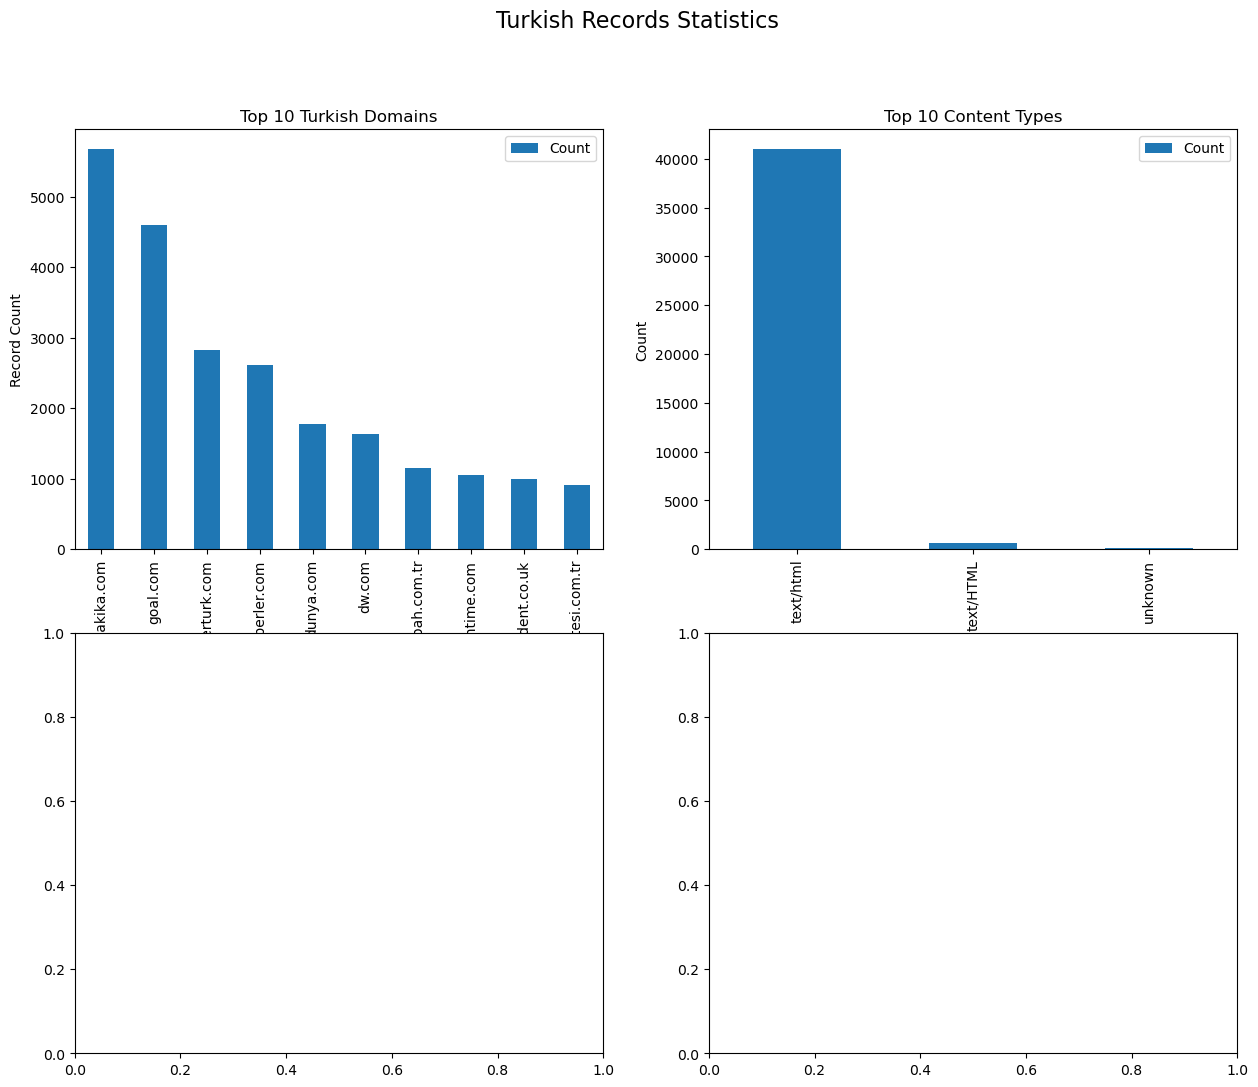

In [34]:
import os
from warcio.archiveiterator import ArchiveIterator
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import re
from urllib.parse import urlparse
import json

def normalize_url(url):
    """Normalize URL to improve matching"""
    if not url:
        return ""
    
    # Parse URL
    parsed = urlparse(url)
    
    # Convert to lowercase
    netloc = parsed.netloc.lower()
    
    # Remove 'www.' if present
    if netloc.startswith('www.'):
        netloc = netloc[4:]
    
    # Extract domain only for matching against turkish-urls.txt
    return netloc

def load_turkish_urls(filepath):
    """Load Turkish URLs from the specified file"""
    turkish_domains = set()
    try:
        with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
            for line in f:
                line = line.strip()
                if line and not line.startswith('//'):
                    # Clean up the domain
                    domain = line.lower()
                    if domain.startswith('www.'):
                        domain = domain[4:]
                    turkish_domains.add(domain)
        print(f"Loaded {len(turkish_domains)} Turkish domains from {filepath}")
    except Exception as e:
        print(f"Error loading Turkish URLs from {filepath}: {e}")
    
    return turkish_domains

def extract_turkish_records(warc_path, turkish_domains):
    """Extract records that match Turkish domains"""
    turkish_records = defaultdict(list)
    total_records = 0
    
    try:
        with open(warc_path, 'rb') as f:
            for record in ArchiveIterator(f):
                if record.rec_type == 'response':
                    total_records += 1
                    
                    # Extract URL
                    url = record.rec_headers.get_header('WARC-Target-URI')
                    if url:
                        normalized_domain = normalize_url(url)
                        
                        # Check if the normalized domain matches any Turkish domain
                        for turkish_domain in turkish_domains:
                            if turkish_domain in normalized_domain:
                                # Store the full record info
                                record_info = {
                                    'url': url,
                                    'domain': normalized_domain,
                                    'status': record.http_headers.get_header('Status', '').split()[0] if record.http_headers.get_header('Status') else None,
                                    'content_type': record.http_headers.get_header('Content-Type', 'unknown').split(';')[0].strip(),
                                    'content_length': record.http_headers.get_header('Content-Length'),
                                    'warc_file': os.path.basename(warc_path)
                                }
                                
                                turkish_records[turkish_domain].append(record_info)
                                break
    except Exception as e:
        print(f"Error processing {warc_path}: {e}")
    
    return turkish_records, total_records

def process_all_warc_files(turkish_domains):
    """Process all WARC files and extract Turkish records"""
    warc_files = [f for f in os.listdir('.') if f.endswith('.warc')]
    
    if not warc_files:
        print("No WARC files found in the current directory")
        return None
    
    print(f"Found {len(warc_files)} WARC files: {', '.join(warc_files)}")
    
    all_turkish_records = defaultdict(list)
    total_records_analyzed = 0
    
    for warc_file in tqdm(warc_files, desc="Processing WARC files"):
        turkish_records, total_records = extract_turkish_records(warc_file, turkish_domains)
        total_records_analyzed += total_records
        
        # Merge the results
        for domain, records in turkish_records.items():
            all_turkish_records[domain].extend(records)
    
    return all_turkish_records, total_records_analyzed

def create_statistics_report(all_turkish_records, total_records_analyzed):
    """Create and display statistics about the extracted Turkish records"""
    
    # Calculate statistics
    total_turkish_records = sum(len(records) for records in all_turkish_records.values())
    domains_with_records = {domain: len(records) for domain, records in all_turkish_records.items() if records}
    
    # Sort domains by number of records
    sorted_domains = sorted(domains_with_records.items(), key=lambda x: x[1], reverse=True)
    
    # Content type distribution
    all_content_types = Counter()
    for records in all_turkish_records.values():
        for record in records:
            all_content_types[record['content_type']] += 1
    
    # Status code distribution
    all_status_codes = Counter()
    for records in all_turkish_records.values():
        for record in records:
            if record['status']:
                all_status_codes[record['status']] += 1
    
    # Display summary statistics
    print("\n=== Turkish Records Summary Statistics ===")
    print(f"Total WARC records analyzed: {total_records_analyzed}")
    print(f"Total Turkish records found: {total_turkish_records} ({total_turkish_records/total_records_analyzed*100:.2f}% of total records)")
    print(f"Total unique Turkish domains with records: {len(domains_with_records)}")
    
    # Display top domains
    print("\nTop 20 Turkish domains by record count:")
    for domain, count in sorted_domains[:20]:
        print(f"  {domain}: {count} records")
    
    # Display content type distribution
    print("\nContent type distribution:")
    for content_type, count in all_content_types.most_common(10):
        print(f"  {content_type}: {count}")
    
    # Display status code distribution
    print("\nStatus code distribution:")
    for status, count in all_status_codes.most_common():
        print(f"  {status}: {count}")
    
    return {
        'total_records_analyzed': total_records_analyzed,
        'total_turkish_records': total_turkish_records,
        'domains_with_records': domains_with_records,
        'content_types': {k: int(v) for k, v in dict(all_content_types).items()},
        'status_codes': {k: int(v) for k, v in dict(all_status_codes).items()}
    }

def visualize_statistics(stats):
    """Create visualizations of the Turkish record statistics"""
    # Create a figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Turkish Records Statistics', fontsize=16)
    
    # Top 10 domains
    top_domains = dict(sorted(stats['domains_with_records'].items(), key=lambda x: x[1], reverse=True)[:10])
    domain_df = pd.DataFrame.from_dict(top_domains, orient='index', columns=['Count'])
    domain_df.plot(kind='bar', ax=axs[0, 0], title='Top 10 Turkish Domains')
    axs[0, 0].set_ylabel('Record Count')
    
    # Content Types
    content_df = pd.DataFrame.from_dict({k: v for k, v in sorted(stats['content_types'].items(), 
                                                          key=lambda x: x[1], reverse=True)[:10]}, 
                                      orient='index', columns=['Count'])
    content_df.plot(kind='bar', ax=axs[0, 1], title='Top 10 Content Types')
    axs[0, 1].set_ylabel('Count')
    
    # Status Codes - FIX: Ensure numeric data
    status_codes = {k: int(v) for k, v in stats['status_codes'].items()}
    status_df = pd.DataFrame.from_dict(status_codes, orient='index', columns=['Count'])
    # Make sure the index is string to avoid issues
    status_df.index = status_df.index.astype(str)
    status_df.plot(kind='bar', ax=axs[1, 0], title='HTTP Status Codes')
    axs[1, 0].set_ylabel('Count')
    
    # Turkish vs Total Records
    axs[1, 1].pie([stats['total_turkish_records'], stats['total_records_analyzed'] - stats['total_turkish_records']], 
                 labels=['Turkish Records', 'Other Records'], autopct='%1.1f%%')
    axs[1, 1].set_title('Turkish Records vs Total Records')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def export_turkish_records(all_turkish_records):
    """Export the Turkish records to JSON and CSV files"""
    # Flatten the records for CSV export
    flattened_records = []
    for domain, records in all_turkish_records.items():
        for record in records:
            record_copy = record.copy()
            record_copy['turkish_domain'] = domain
            flattened_records.append(record_copy)
    
    # Create a DataFrame
    df = pd.DataFrame(flattened_records)
    
    # Save as CSV
    df.to_csv('turkish_records.csv', index=False)
    print(f"Exported {len(flattened_records)} records to turkish_records.csv")
    
    # Save as JSON (with more detailed structure)
    with open('turkish_records.json', 'w', encoding='utf-8') as f:
        json_data = {
            'record_count': sum(len(records) for records in all_turkish_records.values()),
            'domains': {domain: {'count': len(records), 'records': records} 
                      for domain, records in all_turkish_records.items()}
        }
        json.dump(json_data, f, indent=2)
    print(f"Exported detailed data to turkish_records.json")

# Main execution
turkish_urls_file = 'turkish-urls-unique.txt'
turkish_domains = load_turkish_urls(turkish_urls_file)

if turkish_domains:
    # Process all WARC files
    all_turkish_records, total_records_analyzed = process_all_warc_files(turkish_domains)
    
    if all_turkish_records:
        # Create statistics report
        stats = create_statistics_report(all_turkish_records, total_records_analyzed)
        
        # Visualize statistics
        visualize_statistics(stats)
        
        # Export the records
        export_turkish_records(all_turkish_records)
        
        # Also export statistics to JSON
        with open('turkish_stats.json', 'w', encoding='utf-8') as f:
            json.dump(stats, f, indent=2)
        print("Exported statistics to turkish_stats.json")
else:
    print(f"No Turkish domains were loaded. Please check the file: {turkish_urls_file}")